In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD", "SOL-USD", "XLM-USD", "DOGE-USD", "XRP-USD", "ADA-USD", "UNI7083-USD", "SEI-USD", "LTC-USD", "LINK-USD",
                  "NEAR-USD","AVAX-USD", "HBAR-USD", "CRV-USD","COTI-USD","FTM-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail())
print(current_hour)

[*********************100%***********************]  16 of 16 completed


Ticker                      ADA-USD   AVAX-USD       BTC-USD  COTI-USD  \
Datetime                                                                 
2024-11-25 07:00:00+00:00  1.039517  44.962955  98148.804688  0.142598   
2024-11-25 08:00:00+00:00  1.066174  46.166462  98337.335938  0.144161   
2024-11-25 09:00:00+00:00  1.064633  46.683155  98575.945312  0.146851   
2024-11-25 10:00:00+00:00  1.062456  45.939068  98412.703125  0.146100   
2024-11-25 11:00:00+00:00  1.062456  45.939068  98389.976562  0.146100   

Ticker                      CRV-USD  DOGE-USD   FTM-USD  HBAR-USD   LINK-USD  \
Datetime                                                                       
2024-11-25 07:00:00+00:00  0.526083  0.428826  0.957490  0.143658  18.270271   
2024-11-25 08:00:00+00:00  0.533530  0.432566  0.956577  0.145338  18.483622   
2024-11-25 09:00:00+00:00  0.541273  0.433171  0.973266  0.146544  18.605602   
2024-11-25 10:00:00+00:00  0.542283  0.430670  0.957259  0.147386  18.833549   
2

In [19]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

              1H  12H   1D    3D  Sharpe
Ticker                                  
BTC-USD      0.6  1.7  2.5   4.3    0.54
SOL-USD      0.9  2.8  4.1   7.1    0.36
LTC-USD      1.1  3.3  4.7   8.2    0.29
LINK-USD     1.1  3.4  4.9   8.7    0.39
AVAX-USD     1.2  3.6  5.2   9.6    0.40
UNI7083-USD  1.3  3.9  5.7  10.2    0.30
NEAR-USD     1.3  4.2  5.9  10.5    0.30
XRP-USD      1.5  4.2  6.0  10.9    0.64
CRV-USD      1.4  4.3  6.1  11.1    0.48
COTI-USD     1.5  4.4  6.3  11.2    0.29
ADA-USD      1.5  4.4  6.4  11.5    0.65
FTM-USD      1.4  4.5  6.4  11.6    0.24
SEI-USD      1.5  4.7  6.8  12.9    0.28
XLM-USD      2.2  5.3  7.6  13.9    0.83
DOGE-USD     1.8  5.4  7.7  13.3    0.55
HBAR-USD     2.2  5.8  8.3  14.9    0.52


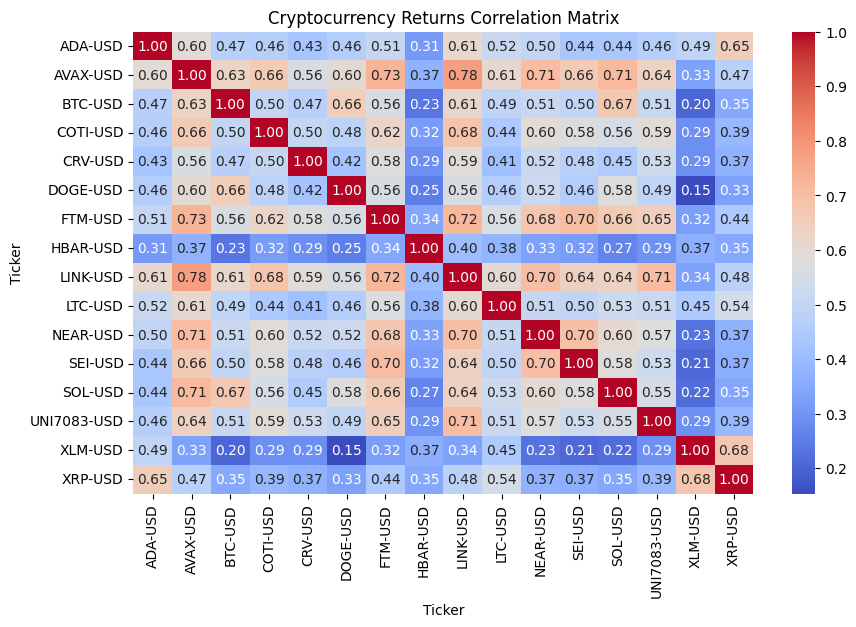

In [20]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [21]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

# recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
             Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                     
ADA-USD               0.9942           0.9407         1.1307         1.1842
AVAX-USD             43.5313          41.5168        48.3468        50.3614
BTC-USD           95969.2121       94141.5523    100810.7410    102638.4008
COTI-USD              0.1369           0.1298         0.1553         0.1624
CRV-USD               0.5092           0.4821         0.5753         0.6024
DOGE-USD              0.3976           0.3734         0.4637         0.4879
FTM-USD               0.8958           0.8463         1.0187         1.0682
HBAR-USD              0.1352           0.1254         0.1596         0.1694
LINK-USD             17.9162          17.1981        19.7509        20.4690
LTC-USD              93.8461          90.3658       103.0588       106.5391
NEAR-USD              6.4158           6.1024         7.2273

In [22]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 비중 입력 받기
weights = pd.Series({
    "BTC-USD": 0.23,
    "SOL-USD": 0.19,
    "XLM-USD": 0.0,
    "DOGE-USD": 0.14,
    "XRP-USD": 0.06,
    "ADA-USD": 0.03,
    "LTC-USD": 0.03,
    "LINK-USD": 0.03,
    "UNI7083-USD":0.03,
    "NEAR-USD":0.03,
    "AVAX-USD":0.03,
    "SEI-USD": 0.03,
    "HBAR-USD": 0.03,
    "CRV-USD": 0.03,
    "COTI-USD":0.03,
    "FTM-USD":0.03
})

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))  # W.T * C * W
portfolio_volatility_hourly = np.sqrt(portfolio_variance)  # 포트폴리오 표준편차 (시간별)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())  # 포트폴리오 시간당 기대 수익률
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)  # 95% VaR
var_95_daily = -z_score * portfolio_volatility_daily * 10000  # 포트폴리오 가치 - 손실 금액

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")

Daily Portfolio Volatility: 4.97%
Daily Portfolio Mean: 2.74%


In [23]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
    "BTC-USD": 0.13,
    "SOL-USD": 40,
    "XLM-USD": 7500,
    "DOGE-USD": 10000,
    "XRP-USD": 2000,
    "ADA-USD": 3000,
    "LINK-USD": 150,
    "UNI7083-USD":750,
    "NEAR-USD":225,
    "LTC-USD": 10,
    "AVAX-USD": 40,
    "SEI-USD": 15000000,
    "HBAR-USD": 5000,
    "CRV-USD": 1500,
    "COTI-USD": 5000,
    "FTM-USD": 2000
})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")
print(f"95% VaR (daily, value): ${var_95_daily:,.2f} ({var_95_daily/portfolio_value:.2%})")
print(f"Portfolio_Value: {portfolio_value:,.2f}")

Daily Portfolio Volatility: 7.19%
Daily Portfolio Mean: 1.93%
95% VaR (daily, value): $1,112,675.61 (11.82%)
Portfolio_Value: 9,411,198.47


In [24]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} : ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BTC-USD : $584.47 (0.01%)
SOL-USD : $722.83 (0.01%)
XLM-USD : $705.82 (0.01%)
DOGE-USD : $610.13 (0.01%)
XRP-USD : $371.05 (0.00%)
ADA-USD : $389.33 (0.00%)
UNI7083-USD : $899.72 (0.01%)
SEI-USD : $1109426.72 (11.79%)
LTC-USD : $88.79 (0.00%)
LINK-USD : $240.95 (0.00%)
NEAR-USD : $159.28 (0.00%)
AVAX-USD : $170.85 (0.00%)
HBAR-USD : $131.64 (0.00%)
CRV-USD : $92.27 (0.00%)
COTI-USD : $86.27 (0.00%)
FTM-USD : $220.37 (0.00%)

Total 95% VaR (daily, value): $1114900.51


In [25]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD", "SOL-USD","XRP-USD"]
second_group = ["XLM-USD", "DOGE-USD","ADA-USD", "UNI7083-USD", "SEI-USD", "LTC-USD", "LINK-USD", "NEAR-USD","AVAX-USD", "HBAR-USD", "CRV-USD","COTI-USD","FTM-USD"]

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.7},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.3}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x
optimal_weights=pd.Series(optimized_results.x)
optimal_weights = optimal_weights.sort_values(ascending=False)

optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(3)):
    print(f"{crypto_symbols[i]}: {weight:.1%}")

print(f"\nExpected Daily Return: {optimal_return:.2%}")
print(f"Daily Volatility: {optimal_volatility:.2%}")
print(f"Sharpe Ratio: {optimal_sharpe:.2f}")

Optimal Portfolio:
BTC-USD: 28.4%
SOL-USD: 22.8%
XLM-USD: 18.8%
DOGE-USD: 3.0%
XRP-USD: 2.5%
ADA-USD: 2.5%
UNI7083-USD: 2.4%
SEI-USD: 2.3%
LTC-USD: 2.3%
LINK-USD: 2.2%
NEAR-USD: 2.2%
AVAX-USD: 2.2%
HBAR-USD: 2.2%
CRV-USD: 2.1%
COTI-USD: 2.1%
FTM-USD: 2.1%

Expected Daily Return: 2.72%
Daily Volatility: 4.73%
Sharpe Ratio: 0.57
